In [1]:
import sqlite3
import pandas as pd
import matplotlib as rc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# set style for seaborn
sns.set_style("whitegrid")
sns.set_context("paper")
rc.use("pgf")
rc.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')


In [2]:
# connect to database
connection = sqlite3.connect("../output/db/bulk_analysis_2019-11-08_1000ms.db")


In [3]:
# load games and moves into dataframes 
df_game_dirty = pd.read_sql("SELECT * FROM game", connection)
df_move_dirty = pd.read_sql("SELECT * FROM move", connection)

# remove games that are either too short or too long
df_game = remove_outlier(df_game_dirty, "length")
df_move = df_move_dirty[df_move_dirty["game_id"].isin(df_game["id"])]
df_move.head()


,id,fullmove_number,ply_number,turn,san,lan,score,score_change,score_change_category,move_count,...,guarded_pieces_centipawn_all,attacked_guarded_pieces_centipawn_all,unopposed_threats_centipawn_all,threats_centipawn_all,attack_defense_relation1,attack_defense_relation2,material,pawn_ending,rook_ending,game_id
0,1,1,1,1,d4,d2-d4,-10,10,0.20,20,...,5800,0,0,0,0,-600,0,0,0,1
1,2,1,2,0,g6,g7-g6,118,128,2.56,20,...,5800,0,0,0,0,-500,0,0,0,1
2,3,2,3,1,c4,c2-c4,37,81,1.62,28,...,5700,0,0,0,0,-1500,0,0,0,1
3,4,2,4,0,Bg7,Bf8-g7,106,69,1.38,21,...,5900,100,0,0,600,-2100,0,0,0,1
4,5,3,5,1,Nf3,Ng1-f3,43,63,1.26,30,...,5900,100,0,0,900,-1300,0,0,0,1


Text(0.5, 0, 'ply')

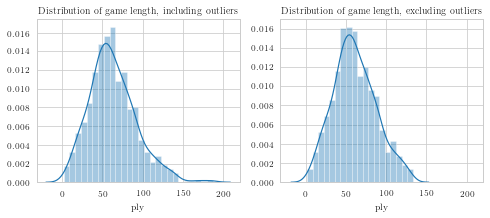

In [4]:
# not clean distribution
f, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)
dist_dirty = sns.distplot(df_game_dirty["length"], ax=axes[0])
axes[0].set_title("Distribution of game length, including outliers")
axes[0].set_xlabel("ply")
# not clean distribution
dist_clean = sns.distplot(df_game["length"], ax=axes[1])
axes[1].set_title("Distribution of game length, excluding outliers")
axes[1].set_xlabel("ply")

In [6]:
f.savefig("dist_game_length.pgf")
f.savefig("dist_game_length.pdf")


Text(0.5, 0, 'ply')

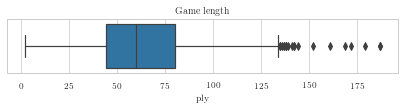

In [12]:
plt.figure(figsize=(7, 1))
box_game_length = sns.boxplot(x=df_game_dirty["length"])
box_game_length.set_title("Game length")
box_game_length.set_xlabel("ply")

In [13]:
fig = box_game_length.get_figure()
fig.savefig("boxplot_game_length.pgf")
fig.savefig("boxplot_game_length.pdf")



Text(0.5, 0, 'ply')

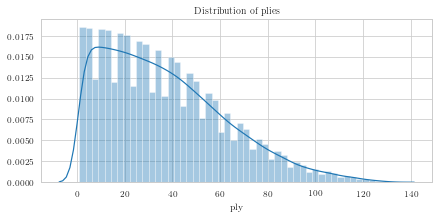

In [14]:
plt.figure(figsize=(7, 3))
dist_plies = sns.distplot(df_move["ply_number"])
dist_plies.set_title("Distribution of plies")
dist_plies.set_xlabel("ply")


In [16]:
fig = dist_plies.get_figure()
fig.savefig("dist_plies.pgf")
fig.savefig("dist_plies.pdf")


Text(0.5, 0, 'ply')

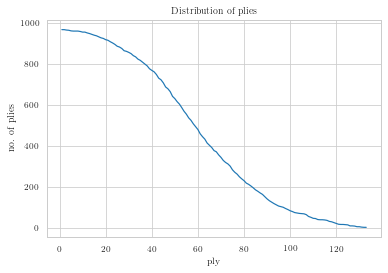

In [19]:
df_plies_count = df_move.groupby(["ply_number"]).size().reset_index(name="count")
line_plies = sns.lineplot(x="ply_number", y="count", data=df_plies_count)
line_plies.set_title("Distribution of plies")
line_plies.set_xlabel("ply")
line_plies.set_ylabel("no. of plies")


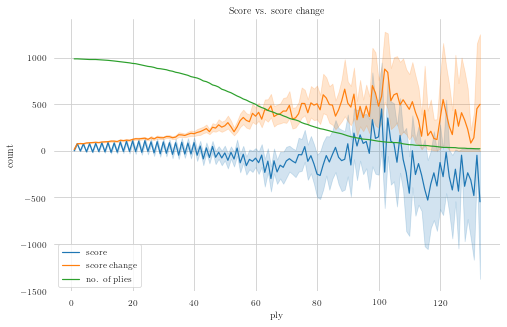

In [36]:
f, ax = plt.subplots(figsize=(8, 5))
line_score = sns.lineplot(x="ply_number", y="score", data=df_move_dirty.query("ply_number <= 133"), legend="brief")
sns.lineplot(x="ply_number", y="score_change", data=df_move_dirty.query("ply_number <= 133"))
line_plies = sns.lineplot(x="ply_number", y="count", data=df_move_dirty.query("ply_number <= 133").groupby(["ply_number"]).size().reset_index(name="count"))
sns.despine(left=True, bottom=True)
line_score.set_title("Score vs. score change")
line_score.set_xlabel("ply")
ax.legend(labels=["score", "score change", "no. of plies"], loc=3)

In [37]:
f.savefig("scorevsscorechange.pgf")
f.savefig("scorevsscorechange.pdf")
